# Exercise - Ensemble

In this exercise, we will focus on underage drinking. The data set contains data about high school students. Each row represents a single student. The columns include the characteristics of deidentified students. This is a binary classification task: predict whether a student drinks alcohol or not (this is the **alc** column: 1=Yes, 0=No). This is an important prediction task to detect underage drinking and deploy intervention techniques. 

## Description of Variables

The description of variables are provided in "Alcohol - Data Dictionary.docx"

## Goal

Use the **alcohol.csv** data set and build a model to predict **alc**. 

# Read and Prepare the Data

In [74]:
# Common imports

import pandas as pd
import numpy as np

np.random.seed(42)

# Get the data

In [77]:
#We will predict the "price" value in the data set:

alcohol = pd.read_csv("alcohol.csv")
alcohol.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,gender,alc
0,18,2,1,4,2,0,5,4,2,5,2,M,1
1,18,4,3,1,0,0,4,4,2,3,9,M,1
2,15,4,3,2,3,0,5,3,4,5,0,F,0
3,15,3,3,1,4,0,4,3,3,3,10,F,0
4,17,3,2,1,2,0,5,3,5,5,2,M,1


# Split data (train/test)

In [80]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(alcohol, test_size=0.3)

# Data Prep

In [83]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer

## Separate the target variable 

In [86]:
train_target = train['alc']
test_target = test['alc']

train_inputs = train.drop(['alc'], axis=1)
test_inputs = test.drop(['alc'], axis=1)

## Feature Engineering: Derive a new column

Examples:
- Ratio of study time to travel time
- Student is younger than 18 or not
- Average of father's and mother's level of education
- (etc.)

In [89]:
train_inputs['age'].describe()

count    23800.000000
mean        16.300798
std          1.049183
min         13.000000
25%         16.000000
50%         16.000000
75%         17.000000
max         20.000000
Name: age, dtype: float64

<Axes: >

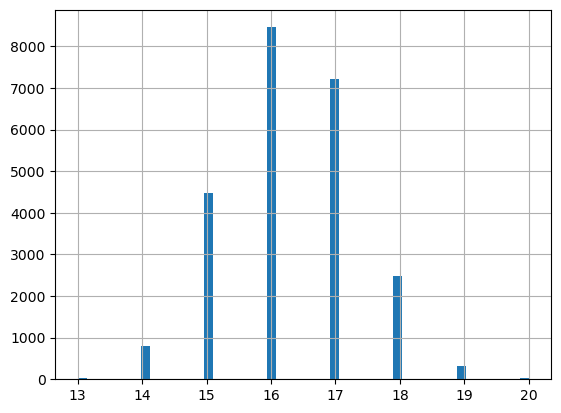

In [91]:
train_inputs['age'].hist(bins=50)

In [93]:
def new_col(df):
    
    #Create a copy so that we don't overwrite the existing dataframe
    df1 = df.copy()

    # Use the formula, though fill in 0s when the value is 0/0 (because 0/0 generates "nan" values)
    df1['study_vs_travel'] = (df1['studytime']/df1['traveltime']).fillna(0)

    # Replace the infinity values with 1 (because a value divided by 0 generates infinity)
    df1['study_vs_travel'].replace(np.inf, 1, inplace=True)

    return df1[['study_vs_travel']]
    # You can use this to check whether the calculation is made correctly:
    #return df1

In [95]:
#Let's test the new function:

# Send the train set to the function we created
new_col(train_inputs)

/var/folders/x3/xjqdf_1561zch36b9hs3lr_80000gn/T/ipykernel_58256/821134817.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['study_vs_travel'].replace(np.inf, 1, inplace=True)


,study_vs_travel
12759,1.0
4374,1.5
8561,1.0
10697,2.0
19424,4.0
...,...
16850,1.0
6265,2.0
11284,1.5
860,1.5


In [97]:
train_target

12759    1
4374     0
8561     1
10697    0
19424    0
        ..
16850    1
6265     1
11284    1
860      1
15795    1
Name: alc, Length: 23800, dtype: int64

##  Identify the numeric, binary, and categorical columns

In [100]:
# Identify the numerical columns
numeric_columns = train_inputs.select_dtypes(include=[np.number]).columns.to_list()

# Identify the categorical columns
categorical_columns = train_inputs.select_dtypes('object').columns.to_list()

In [102]:
numeric_columns

['age',
 'Medu',
 'Fedu',
 'traveltime',
 'studytime',
 'failures',
 'famrel',
 'freetime',
 'goout',
 'health',
 'absences']

In [104]:
categorical_columns

['gender']

In [106]:
feat_eng_columns= ['studytime','traveltime']

# Pipeline

In [109]:
numeric_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

In [111]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [113]:
# Create a pipeline for the transformed column here
my_new_column = Pipeline(steps=[('my_new_column', FunctionTransformer(new_col)),
                               ('scaler', StandardScaler())])


In [115]:
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns),
    ('trans', my_new_column, feat_eng_columns)], remainder='passthrough')
#passtrough is an optional step. You don't have to use it.

# Transform: fit_transform() for TRAIN

In [118]:
#Fit and transform the train data
train_x = preprocessor.fit_transform(train_inputs)

train_x

/var/folders/x3/xjqdf_1561zch36b9hs3lr_80000gn/T/ipykernel_58256/821134817.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['study_vs_travel'].replace(np.inf, 1, inplace=True)


array([[ 0.66643886,  0.96597412,  0.90362635, ...,  1.        ,
         0.        , -0.6645619 ],
       [ 0.66643886, -0.93881619, -1.68666277, ...,  0.        ,
         1.        , -0.0495349 ],
       [ 0.66643886,  0.33104402,  0.04019664, ...,  0.        ,
         1.        , -0.6645619 ],
       ...,
       [ 0.66643886, -2.20867639, -2.55009248, ...,  1.        ,
         0.        , -0.0495349 ],
       [ 1.6195814 , -0.30388608, -1.68666277, ...,  0.        ,
         1.        , -0.0495349 ],
       [ 1.6195814 , -0.30388608, -2.55009248, ...,  0.        ,
         1.        , -0.6645619 ]])

In [120]:
train_x.shape

(23800, 14)

# Tranform: transform() for TEST

In [123]:
# Transform the test data
test_x = preprocessor.transform(test_inputs)

test_x

/var/folders/x3/xjqdf_1561zch36b9hs3lr_80000gn/T/ipykernel_58256/821134817.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['study_vs_travel'].replace(np.inf, 1, inplace=True)


array([[-1.23984621,  0.33104402,  1.76705606, ...,  1.        ,
         0.        ,  0.5654921 ],
       [-1.23984621, -0.30388608,  0.04019664, ...,  0.        ,
         1.        , -1.2795889 ],
       [-0.28670367,  0.33104402,  0.04019664, ...,  0.        ,
         1.        ,  0.5654921 ],
       ...,
       [ 0.66643886, -0.30388608,  0.04019664, ...,  1.        ,
         0.        , -0.6645619 ],
       [-1.23984621, -0.93881619,  0.04019664, ...,  0.        ,
         1.        , -0.0495349 ],
       [-1.23984621,  0.96597412,  0.04019664, ...,  1.        ,
         0.        , -0.6645619 ]])

In [125]:
test_x.shape

(10200, 14)

# Calculate the Baseline

Multiclass Classification: Hard voting

In [4]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import SGDClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier


dtree_clf = DecisionTreeClassifier(max_depth=20)
log_clf = LogisticRegression(multi_class='multinomial', solver = 'lbfgs', C=10, max_iter=1000)
sgd_clf = SGDClassifier(max_iter=10000, tol=1e-3)

voting_clf = VotingClassifier(
            estimators=[('dt', dtree_clf), 
                        ('lr', log_clf), 
                        ('sgd', sgd_clf)],
            voting='hard')

voting_clf.fit(train_x, train_target)

NameError: name 'train_x' is not defined

In [6]:
from sklearn.metrics import accuracy_score

In [67]:
#Train accuracy

train_y_pred = voting_clf.predict(train_x)

train_acc = accuracy_score(train_target, train_y_pred)

print('Train acc: {}' .format(train_acc))

NotFittedError: This VotingClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
#Test accuracy

test_y_pred = voting_clf.predict(test_x)

test_acc = accuracy_score(test_target, test_y_pred)

print('Test acc: {}' .format(test_acc))

# Train a voting classifier 

Hard voting

In [90]:
dtree_clf = DecisionTreeClassifier(max_depth=20)
log_clf = LogisticRegression(multi_class='multinomial', solver = 'lbfgs', C=10, max_iter=1000)
sgd_clf = SGDClassifier(max_iter=10000, tol=1e-3)

voting_clf = VotingClassifier(
            estimators=[('dt', dtree_clf), 
                        ('lr', log_clf), 
                        ('sgd', sgd_clf)],
            voting='hard',
            weights=[0.6, 0.2, 0.2])

voting_clf.fit(train_x, train_target)

VotingClassifier(estimators=[('dt', DecisionTreeClassifier(max_depth=20)),
                             ('lr',
                              LogisticRegression(C=10, max_iter=1000,
                                                 multi_class='multinomial')),
                             ('sgd', SGDClassifier(max_iter=10000))],
                 weights=[0.6, 0.2, 0.2])

In [94]:
#Train accuracy

train_y_pred = voting_clf.predict(train_x)

train_acc = accuracy_score(train_target, train_y_pred)

print('Train acc: {}' .format(train_acc))

Train acc: 0.965546218487395


In [98]:
#Test accuracy

test_y_pred = voting_clf.predict(test_x)

test_acc = accuracy_score(test_target, test_y_pred)

print('Test acc: {}' .format(test_acc))

Test acc: 0.7548039215686274


Soft voting

In [103]:
#Each model should have predict_proba() function. Otherwise, you can't use it for soft voting
#We can't use sgd, because it doesn't have predict_proba() function.

voting_clf = VotingClassifier(
            estimators=[('dt', dtree_clf), 
                        ('lr', log_clf)],
            voting='soft')

voting_clf.fit(train_x, train_target)

VotingClassifier(estimators=[('dt', DecisionTreeClassifier(max_depth=20)),
                             ('lr',
                              LogisticRegression(C=10, max_iter=1000,
                                                 multi_class='multinomial'))],
                 voting='soft')

In [107]:
#Train accuracy

train_y_pred = voting_clf.predict(train_x)

train_acc = accuracy_score(train_target, train_y_pred)

print('Train acc: {}' .format(train_acc))

Train acc: 0.9634033613445379


In [109]:
#Test accuracy

test_y_pred = voting_clf.predict(test_x)

test_acc = accuracy_score(test_target, test_y_pred)

print('Test acc: {}' .format(test_acc))

Test acc: 0.7604901960784314


# Train a bagging classifier

In [114]:
from sklearn.ensemble import BaggingClassifier 


#If you want to do pasting, change "bootstrap=False"
#n_jobs=-1 means use all CPU cores
#bagging automatically performs soft voting

bag_clf = BaggingClassifier( 
            SGDClassifier(), n_estimators=50, 
            max_samples=1000, bootstrap=True, n_jobs=-1) 

bag_clf.fit(train_x, train_target)

BaggingClassifier(estimator=SGDClassifier(), max_samples=1000, n_estimators=50,
                  n_jobs=-1)

In [118]:
#Train accuracy

train_y_pred = bag_clf.predict(train_x)

train_acc = accuracy_score(train_target, train_y_pred)

print('Train acc: {}' .format(train_acc))

Train acc: 0.8222689075630252


In [122]:
#Test accuracy

test_y_pred = bag_clf.predict(test_x)

test_acc = accuracy_score(test_target, test_y_pred)

print('Test acc: {}' .format(test_acc))

Test acc: 0.822156862745098


# Train a random forest classifier

In [127]:
from sklearn.ensemble import RandomForestClassifier 

rnd_clf = RandomForestClassifier(n_estimators=500, max_depth=10, n_jobs=-1) 

rnd_clf.fit(train_x, train_target)

RandomForestClassifier(max_depth=10, n_estimators=500, n_jobs=-1)

In [131]:
#Train accuracy

train_y_pred = rnd_clf.predict(train_x)

train_acc = accuracy_score(train_target, train_y_pred)

print('Train acc: {}' .format(train_acc))

Train acc: 0.8450840336134454


In [135]:
#Test accuracy

test_y_pred = rnd_clf.predict(test_x)

test_acc = accuracy_score(test_target, test_y_pred)

print('Test acc: {}' .format(test_acc))

Test acc: 0.8126470588235294


# Train an adaboost classifier

In [140]:
from sklearn.ensemble import AdaBoostClassifier 


ada_clf = AdaBoostClassifier( 
            DecisionTreeClassifier(max_depth=5), n_estimators=500, 
            learning_rate=0.1) 


ada_clf.fit(train_x, train_target)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5),
                   learning_rate=0.1, n_estimators=500)

In [144]:
#Train accuracy

train_y_pred = ada_clf.predict(train_x)

train_acc = accuracy_score(train_target, train_y_pred)

print('Train acc: {}' .format(train_acc))

Train acc: 0.8819747899159663


In [146]:
#Test accuracy

test_y_pred = ada_clf.predict(test_x)

test_acc = accuracy_score(test_target, test_y_pred)

print('Test acc: {}' .format(test_acc))

Test acc: 0.8180392156862745


# Train a gradient boosting classifier

In [148]:
#Use GradientBoosting

from sklearn.ensemble import GradientBoostingClassifier

gbclf = GradientBoostingClassifier(max_depth=2, n_estimators=100, learning_rate=0.1) 

gbclf.fit(train_x, train_target)

GradientBoostingClassifier(max_depth=2)

In [150]:
#Train accuracy

train_y_pred = gbclf.predict(train_x)

train_acc = accuracy_score(train_target, train_y_pred)

print('Train acc: {}' .format(train_acc))

Train acc: 0.8191176470588235


In [152]:
#Test accuracy

test_y_pred = gbclf.predict(test_x)

test_acc = accuracy_score(test_target, test_y_pred)

print('Test acc: {}' .format(test_acc))

Test acc: 0.8115686274509804
